# Business Analysis: What Makes a Successful Film?
## Overview
This project analyzes different characteristics of films to determine what makes films more successful than others. Descriptive analysis of movie data from multiple sources shows that movies from certain studios, certain genres, and certain runtimes perfrom better than others based on profit, revenue and popularity. Movie producers can use this analysis to create movies that will perform successfully.
## Business Problem
A new movie producer wants as much information on the industry before they start making films. The soon to be producer we are providing this analysis for wants to know ways that they can assure movies they make will be successful. We have been tasked with providing actionable insights that will help forge how they make movies.
## Data Sources
The data used for this analysis comes from four different sources and were used for these main DataFrames:
1. [IMDB](https://www.imdb.com/) - `less_90`,`more_90`,`all_runtime`
2. [TheMovieDB](https://www.themoviedb.org/) - `df_gross`
3. [Box Office Mojo](https://www.boxofficemojo.com/) - `df_gross`
4. [The Numbers](https://www.the-numbers.com/) - `budgets`

The most important information used from these sources were movie titles, runtime, revenue, profit, studios, genre, and popularity.

In [1]:
#importing everything we will need
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from statsmodels.formula.api import ols
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import linear_rainbow

## Discovering the Relationship Between Total Gross Revenue and Production Studios
### Initial Exploration and Cleaning of the DataFrame (loading `bom.movie_gross.csv.gz`)

In [2]:
df_gross = pd.read_csv("./zippedData/bom.movie_gross.csv.gz")
df_gross['foreign_gross'] = df_gross['foreign_gross'].str.replace(',', '')
df_gross['foreign_gross'] = df_gross['foreign_gross'].astype(float)
df_gross.dropna(subset=['domestic_gross', 'foreign_gross'], inplace=True)
#computing the total gross
df_gross['total_gross']= df_gross['domestic_gross'] + df_gross['foreign_gross']

### Grouping revenue by `studio` and generationg a DataFrame with top 10 production studios.

In [3]:
studio_group = df_gross.groupby('studio')
avg_total = studio_group['total_gross'].mean()
sorted_avg_total = avg_total.sort_values(ascending=False)
top10studios = pd.DataFrame(sorted_avg_total).head(10)

## Discovering the Relationship Between Movie Ratings and Genre

### Transforming the genre codes into the genre names using `genre_ids`.

In [4]:
df_movies = pd.read_csv("./zippedData/tmdb.movies.csv.gz")
#we retreived the genre codes from The Movie Database website and substituted them for 
#the actual genre name.
genre_mapping = {
    28: "Action",
    12: "Adventure",
    16: "Animation",
    35: "Comedy",
    80: "Crime",
    99: "Documentary",
    18: "Drama",
    10751: "Family",
    14: "Fantasy",
    36: "History",
    27: "Horror",
    10402: "Music",
    9648: "Mystery",
    10749: "Romance",
    878: "Science Fiction",
    10770: "TV Movie",
    53: "Thriller",
    10752: "War",
    37: "Western"
}

import ast

def convert_str_list(s):
    try:
        return ast.literal_eval(s)
    except ValueError as e:
        print(f"Error for string: {s}\nError is: {e}")
        return s    # return the original string in case of error
def get_genre_names(genre_codes):
    return [genre_mapping.get(code, "Undefined") for code in genre_codes]

df_movies['genre_ids'] = df_movies['genre_ids'].apply(convert_str_list)
df_movies['genre_names'] = df_movies['genre_ids'].apply(get_genre_names)

df_movies['genre_names'] = df_movies['genre_names'].apply(lambda x: ', '.join(x))

### Breaking down ratings for each individual genre and generating a DataFrame containing the top genres based on weighted rating with respect to `vote_count`.

In [5]:
df_movies['genre_names'] = df_movies['genre_names'].str.split(', ')
df_exploded = df_movies.explode('genre_names')
df_exploded['weighted_vote'] = df_exploded['vote_count'] * df_exploded['vote_average']
df_weighted = df_exploded.groupby('genre_names').agg({'weighted_vote': 'sum', 'vote_count': 'sum'})
df_weighted['average_rating'] = df_weighted['weighted_vote'] / df_weighted['vote_count']

In [6]:
df_weighted = df_weighted.sort_values(by='average_rating', ascending=False)
df_weighted.reset_index(inplace=True)
df_weighted

,genre_names,weighted_vote,vote_count,average_rating
0,History,1431103.3,195600,7.316479
1,War,1024805.5,141336,7.250846
2,Animation,3643815.3,506612,7.192517
3,Documentary,446405.3,62283,7.167370
4,Music,624432.3,87434,7.141756
5,Western,655407.2,92667,7.072714
6,Family,4588380.8,652585,7.031085
7,Drama,14485381.9,2064637,7.015946
8,Adventure,11288628.2,1645828,6.858936
9,Romance,4249937.6,621223,6.841243


## Discovering Relationship between Runtime and Profit
### Initial SQL Data Exploration (Loading in, creating DataFrames)

In [7]:
#Loading in the SQL data 
conn = sqlite3.connect('./zippedData/im.db/im.db')
q = pd.read_sql("""
SELECT *
FROM sqlite_master

""", conn)
q

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


Here we can see all the tables contained in this SQL database, `movie_basics` is the table we'll go further into.

In [8]:
#Exploring the 'movie_basics' table
q = pd.read_sql("""

SELECT *
FROM movie_basics
LIMIT 10

""", conn)
q

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


In [9]:
#Creating a DataFrame 'less_90' containing all movies with runtimes less than 90 minutes
less_90 = pd.read_sql("""

SELECT DISTINCT primary_title, runtime_minutes
FROM movie_basics
WHERE runtime_minutes < 90

""", conn)
less_90

,primary_title,runtime_minutes
0,The Wandering Soap Opera,80.0
1,A Thin Life,75.0
2,Joe Finds Grace,83.0
3,Nema aviona za Zagreb,82.0
4,Children of the Green Dragon,89.0
...,...,...
62421,A Cherry Tale,85.0
62422,Vida em Movimento,70.0
62423,Drømmeland,72.0
62424,The Rehearsal,51.0


In [10]:
##Creating a DataFrame 'more_90' containing all movies with runtimes more than 90 minutes
more_90 = pd.read_sql("""

SELECT DISTINCT primary_title, runtime_minutes
FROM movie_basics
WHERE runtime_minutes > 90

""", conn)
more_90

,primary_title,runtime_minutes
0,Sunghursh,175.0
1,One Day Before the Rainy Season,114.0
2,The Other Side of the Wind,122.0
3,Pál Adrienn,136.0
4,So Much for Justice!,100.0
...,...,...
44508,The War of Godzilla,102.0
44509,The Last White Witch,97.0
44510,The Mystery of a Buryat Lama,94.0
44511,Kuambil Lagi Hatiku,123.0


### Cleaning the `more_90` and `less_90` DataFrames

In [11]:
# Getting rid of all duplicates, no null values to worry about
more_90.drop_duplicates(subset='primary_title', keep=False, inplace=True)
less_90.drop_duplicates(subset='primary_title', keep=False, inplace=True)

### Loading in `budgets` and Merging with `more_90` and `less_90`

In [12]:
# Loading in a new DataFrame
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [13]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [14]:
# Getting rid of all duplicates, no null values to worry about
budgets.drop_duplicates(subset='movie', keep=False, inplace=True)

In [15]:
# Creating 2 new DataFrames by merging more_90 with budgets and less_90 with budgets.
# Merged using the titles of shared films between the DataFrames.
more_90_budgets = more_90.merge(budgets, how='inner', left_on='primary_title', right_on='movie')
less_90_budgets = less_90.merge(budgets, how='inner', left_on='primary_title', right_on='movie')

In [16]:
more_90_budgets.head()

,primary_title,runtime_minutes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Foodfight!,91.0,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,The Secret Life of Walter Mitty,114.0,37,"Dec 25, 2013",The Secret Life of Walter Mitty,"$91,000,000","$58,236,838","$187,861,183"
2,A Walk Among the Tombstones,114.0,67,"Sep 19, 2014",A Walk Among the Tombstones,"$28,000,000","$26,017,685","$62,108,587"
3,Jurassic World,124.0,34,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864"
4,The Rum Diary,119.0,16,"Oct 28, 2011",The Rum Diary,"$45,000,000","$13,109,815","$21,544,732"


In [17]:
less_90_budgets.head()

,primary_title,runtime_minutes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Piranha 3D,88.0,52,"Aug 20, 2010",Piranha 3D,"$24,000,000","$25,003,155","$83,660,160"
1,Priest,87.0,29,"May 13, 2011",Priest,"$60,000,000","$29,136,626","$84,154,026"
2,Red State,88.0,22,"Sep 23, 2011",Red State,"$4,000,000","$1,065,429","$1,983,596"
3,Please Give,87.0,15,"Apr 30, 2010",Please Give,"$3,000,000","$4,033,574","$4,570,178"
4,The Dead Undead,89.0,7,"Dec 31, 2010",The Dead Undead,"$1,100,000",$0,$0


### Cleaning `more_90_budgets` and `less_90_budgets`

In [18]:
# For columns that will be used, getting rid of dollar signs and commas.
# After this they can be turned into floats.
more_90_budgets['production_budget'] = more_90_budgets['production_budget'].str.strip('$')
more_90_budgets['production_budget'] = more_90_budgets['production_budget'].str.replace(',','')
more_90_budgets['worldwide_gross'] = more_90_budgets['worldwide_gross'].str.strip('$')
more_90_budgets['worldwide_gross'] = more_90_budgets['worldwide_gross'].str.replace(',' , '')
more_90_budgets['worldwide_gross'] = more_90_budgets['worldwide_gross'].astype(float)
more_90_budgets['production_budget'] = more_90_budgets['production_budget'].astype(float)

In [19]:
# Creating a new column named 'profit' using 'worldwide_gross' minus 'production_budget'
more_90_budgets['profit'] = more_90_budgets['worldwide_gross'] - more_90_budgets['production_budget']

#### Repeat the same cleaning process for `less_90_budgets`

In [20]:
# For columns that will be used, getting rid of dollar signs and commas.
# After this they can be turned into floats.
less_90_budgets['production_budget'] = less_90_budgets['production_budget'].str.strip('$')
less_90_budgets['production_budget'] = less_90_budgets['production_budget'].str.replace(',','')
less_90_budgets['worldwide_gross'] = less_90_budgets['worldwide_gross'].str.strip('$')
less_90_budgets['worldwide_gross'] = less_90_budgets['worldwide_gross'].str.replace(',' , '')
less_90_budgets['worldwide_gross'] = less_90_budgets['worldwide_gross'].astype(float)
less_90_budgets['production_budget'] = less_90_budgets['production_budget'].astype(float)

In [21]:
# Creating a new column named 'profit' using 'worldwide_gross' minus 'production_budget'
less_90_budgets['profit'] = less_90_budgets['worldwide_gross'] - less_90_budgets['production_budget']

## Viewing Relationship of `profit` vs. `runtime_minutes` for Films < 90 mins and Films > 90 mins

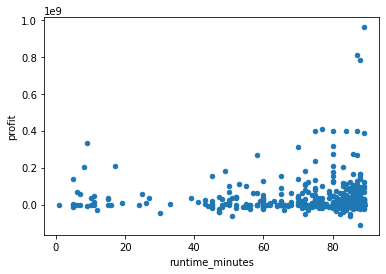

In [22]:
# Scatter plot for movies shorter than 90 minutes
less_90_budgets.plot.scatter(x='runtime_minutes', y='profit');

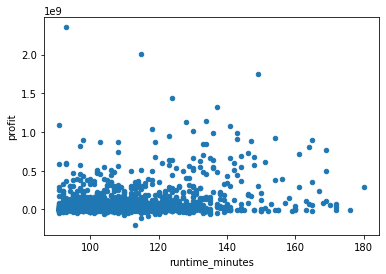

In [23]:
# Scatter plot for movies longer than 90 minutes
more_90_budgets.plot.scatter(x='runtime_minutes', y='profit');

### The means below show a large difference between the average profits. It seems like films with runtimes longer than 90 minutes make more money on average than movies less than 90 minutes.

In [24]:
# Finding the mean profit for 'less_90_budgets' and 'more_90_budgets' 
less_90_budgets['profit'].mean(), more_90_budgets['profit'].mean()

(33499145.77137177, 87142312.36315086)

### We can find out if it's statistically significant with a 2 sample T-test. First, let's state our null hypothesis, alternative hypothesis, and alpha level.
#### H0: Films with a runtime less than 90 mins and films with a runtime greater than 90 minutes return the same amount of profit on average.
#### H1: Films with a runtime less than 90 mins and films with a runtime greater than 90 minutes return a different amount of profit on average.
#### Alpha = 0.05 
#### Now, let's run the test and check the results.

In [25]:
# Running a 2 sample ttest
# alpha = 0.05
tstat, pvalue = stats.ttest_ind(less_90_budgets['profit'], more_90_budgets['profit'], equal_var=False)
tstat, pvalue

(-8.222455972551126, 3.816735173488016e-16)

### The pvalue is < 0.05 meaning we reject the null hypothesis. This concludes that on average, films with a runtime less than 90 mins and films with a runtime greater than 90 minutes return a different amount of profit on average.
#### More specifically, films that are longer than 90 minutes return a greater profit on average.

## Exploring how Runtime influences Popularity
### Creating the `all_runtime`

In [26]:
# Creating a new DataFrame that contains all runtime lengths
all_runtime = pd.read_sql("""

SELECT DISTINCT primary_title, runtime_minutes
FROM movie_basics


""", conn)
all_runtime

,primary_title,runtime_minutes
0,Sunghursh,175.0
1,One Day Before the Rainy Season,114.0
2,The Other Side of the Wind,122.0
3,Sabse Bada Sukh,NaN
4,The Wandering Soap Opera,80.0
...,...,...
145055,Kuambil Lagi Hatiku,123.0
145056,Rodolpho Teóphilo - O Legado de um Pioneiro,NaN
145057,Dankyavar Danka,NaN
145058,6 Gunn,116.0


### Cleaning `all_runtime`

In [27]:
# Getting rid of duplicates
all_runtime.drop_duplicates(subset='primary_title', keep=False, inplace=True)

### Merging `all_runtime` with `budgets`

In [28]:
# Merging using the titles of shared films between the DataFrames.
all_runtime_budgets = all_runtime.merge(budgets, how='inner', left_on='primary_title', right_on='movie')

### Cleaning `all_runtime_budgets` 
Performing the same cleaning processes that were done for `more_90_budgets` and `less_90_budgets`

In [29]:
# For columns that will be used, getting rid of dollar signs and commas.
# After this they can be turned into floats.
all_runtime_budgets['production_budget'] = all_runtime_budgets['production_budget'].str.strip('$')
all_runtime_budgets['production_budget'] = all_runtime_budgets['production_budget'].str.replace(',','')
all_runtime_budgets['production_budget'] = all_runtime_budgets['production_budget'].astype(float)
all_runtime_budgets['worldwide_gross'] = all_runtime_budgets['worldwide_gross'].str.strip('$')
all_runtime_budgets['worldwide_gross'] = all_runtime_budgets['worldwide_gross'].str.replace(',','')
all_runtime_budgets['worldwide_gross'] = all_runtime_budgets['worldwide_gross'].astype(float)

In [30]:
# Creating a new column named 'profit' using 'worldwide_gross' minus 'production_budget'
all_runtime_budgets['profit'] = all_runtime_budgets['worldwide_gross'] - all_runtime_budgets['production_budget']

### Creating `df_movies2`

In [31]:
# Taking only the movie title and popularity rating from 'df_movies' DataFrame
df_movies2 = df_movies[['original_title' , 'popularity']]

### Merging `df_movies2` and `budgets` into `df_movies2_budgets`


In [32]:
# Merged using the titles of the movies
df_movies2_budgets = df_movies2.merge(all_runtime_budgets, how='inner', left_on='original_title', right_on='movie')

### Cleaning `df_movies2_budgets`

In [33]:
# Getting rid of null values
df_movies2_budgets.dropna(subset=['runtime_minutes'], inplace=True)

### Visually exploring the relationship between `runtime_minutes` and `popularity`

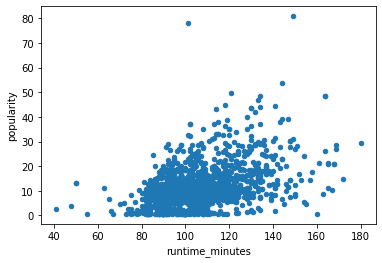

In [34]:
# Creating scatter plot
df_movies2_budgets.plot.scatter(x='runtime_minutes', y='popularity');

Above it's evident that there are some outliers that will poorly affect a linear regression. There looks to be about 8 values at the lowest end of `runtime_minutes` that are less than ~70 minutes. Then there are the two highest points with `popularity` greater than 70. It is in our best interest to get rid of these outliers to improve the results of a linear regression.

### Getting rid of the outliers

In [35]:
# Only keeping movies that have a runtime greater than or equal to 70 minutes 
df_movies2_budgets = df_movies2_budgets[df_movies2_budgets['runtime_minutes'] >= 70]

In [36]:
# Only keeping movies that have a popularity score of less than 65
df_movies2_budgets = df_movies2_budgets[df_movies2_budgets['popularity'] < 65]

### Visually exploring the relationship now that the outliers are gone

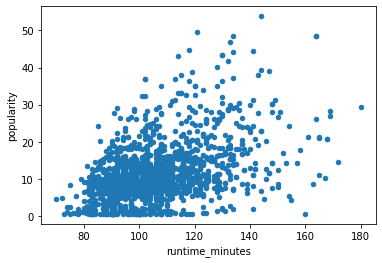

In [37]:
# Creating scatter plot
df_movies2_budgets.plot.scatter(x='runtime_minutes', y='popularity');

The scatter plot above looks a lot better.

### Rainbow test of linearity
To make sure our data is linear (one of the four assumptions made when running a linear regression) we can run a rainbow test. The null hypothesis of this test is that the data is linear. We will set our alpha level at 0.01.

In [38]:
# Running the rainbow test
model = ols("popularity ~ runtime_minutes", data=df_movies2_budgets).fit()
F_statistic, p_value = linear_rainbow(res=model, frac=0.5)
F_statistic, p_value

(1.1652991248217697, 0.019043354006588454)

The pvalue is > 0.01, meaning we fail to reject the null hypothesis and we can safely assume that our data is linear based on our test results.

### Linear Regression for `runtime_minutes` and `popularity`

In [39]:
# Running the linear regression and printing the R-Squared value
X = df_movies2_budgets[['runtime_minutes']]  
y = df_movies2_budgets['popularity']  
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r_squared = model.score(X, y)
print("R-squared value: ", r_squared)

R-squared value:  0.19354842598937083


This R-Squared value means that about 19% of the popularity score a movie receives is explained by the runtime of the movie.

## Conclusion
Based on our data analysis we have three final recommendations:
1. Work with one of our top studios because they have the highest gross revenues.
2. Make movies under one of our top genres because these types of movies earn the highest ratings.
3. Make movies that are longer than 90 minutes and aim around 120 minutes in length. These movies return the highest profits.

## Next Steps

- Explore which age rating (P, PG, PG-13, R) would be best
- Explore which actors bring in the most revenue
- Explore which directors are best for each genre